# MTL, Policies, and Experiments

In this file, we're going to be taking a look at what makes MTL hard (gradient conflicts), and how traditional models rely on static or rigid rule based heuristics to resolve them. We will also take a look at why these methods are often unable to converge to the Pareto front, which provides us the incentive to resort to a trained policy model.

---

## 1. Gradient Interference and Negative Transfer

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity

# Lets create a shared parameter vector (this is our mock "Neural Network")
# Initialized at (0,0)
theta = torch.tensor([0.0, 0.0], requires_grad=True)

print(f"Initial parameters: {theta}")


Initial parameters: tensor([0., 0.], requires_grad=True)


### Simulate Gradient Conflicts
We can define two simple loss functions, lets say:
- Task A wants parameters to move to (2,2)
- Task B wants parameters to move to (-2,-2)

We further multiply Task B's loss by 10.0 to simulate a task that is not only opposing, but also has a larger magnitude.

In [ ]:
def get_task_gradients(theta_input):
    if theta_input.grad is not None:
        theta_input.grad.zero_() # reset the gradients

    # Task A - gradient want to move to (2,2)
    target_A = torch.tensor([2.0, 2.0])
    loss_A = torch.sum((theta_input - target_A) ** 2)
    loss_A.backward(retain_graph=True)

    grad_A = theta_input.grad.clone() #saving the gradient

    
    
    theta_input.grad.zero_() # reset the gradients for Task B again


    # Task B - gradient want to move to (-2,2)
    target_B = torch.tensor([-2.0, -2.0])
    loss_B = torch.sum((theta_input - target_B) ** 2) * 10.0 # magnitude imbalanced!!!
    loss_B.backward(retain_graph=True)

    grad_B = theta_input.grad.clone() # saving the gradient


    return grad_A, grad_B


g_A, g_B = get_task_gradients(theta)

print(f"Task A Gradient: {g_A.numpy()}")
print(f"Task B Gradient: {g_B.numpy()}")



# Cosine similarity between gradients to show they are actually opposing

cos_sim = cosine_similarity(g_A, g_B, dim=0)

print(f"Cosine Similarity between Task A and Task B gradients: {cos_sim}")




Task A Gradient: [-4. -4.]
Task B Gradient: [40. 40.]
Cosine Similarity between Task A and Task B gradients: -0.9999999403953552


The cosine similarity being this close to -1 means the gradients are in the opposing directions!

But lets plot and visually see this as well.

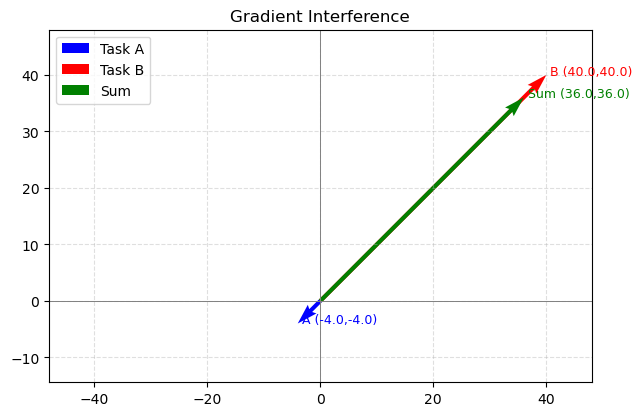

In [41]:
s = g_A + g_B

plt.figure(figsize=(7,7))
plt.axhline(0, color='gray', lw=0.7)
plt.axvline(0, color='gray', lw=0.7)

plt.quiver(0, 0, g_A[0], g_A[1], color='blue', angles='xy', scale_units='xy', scale=1, label='Task A')
plt.quiver(0, 0, g_B[0], g_B[1], color='red', angles='xy', scale_units='xy', scale=1, label='Task B')
plt.quiver(0, 0, s[0], s[1], color='green',angles='xy', scale_units='xy', scale=1, label='Sum')


plt.text(g_A[0], g_A[1], f' A ({g_A[0]},{g_A[1]})', color='blue', fontsize=9)
plt.text(g_B[0], g_B[1], f' B ({g_B[0]},{g_B[1]})', color='red', fontsize=9)
plt.text(s[0], s[1], f' Sum ({s[0]},{s[1]})', color='green',fontsize=9)


lim = max(1.0, np.max(np.abs(np.concatenate([g_A, g_B, s])))) * 1.2
plt.xlim(-lim, lim)
plt.ylim(-0.3*lim, lim)

plt.gca().set_aspect('equal', adjustable='box')

plt.grid(alpha=0.4, linestyle='--')

plt.legend()
plt.title('Gradient Interference')
plt.show()

The Blue arrow is where Task A wants to go. The Red arrow is where Task B wants to go. They are strictly opposed (**Directional Conflict**). However, because Task B has a larger loss scale, the Red arrow is huge. When we simply add them together (Green arrow), the model completely ignores Task A and moves almost exclusively in the direction of Task B (**Magnitude Conflict**)

### Now, lets demonstrate WHY gradient conflicts are such a problem: **Negative Transfer!**
We will create a training loop to show how combining these tasks hurt performance
- Single Task - training only on task A
- Multi Task - training on both Task A and B

Then we compare the final loss of Task A in both scenarios

In [50]:
def train_model(mode, steps=50):
    # reinit model parameters to 0,0
    theta = torch.tensor([0.0, 0.0], requires_grad=True)

    optimizer = torch.optim.SGD([theta], lr=0.1)

    history_loss_A = []

    for i in range(0, steps):
        optimizer.zero_grad()

        target_A = torch.tensor([2.0, 2.0])
        loss_A = torch.sum((theta - target_A) ** 2)

        target_B = torch.tensor([-2.0, -2.0])
        loss_B = torch.sum((theta - target_B) ** 2) * 10.0 # magnitude imbalanced!!!

        if mode == 'MTL':
            final_loss = loss_A + loss_B
        
        elif mode == 'STL':
            final_loss = loss_A


        final_loss.backward()
        optimizer.step()

        history_loss_A.append(loss_A.item())

    return theta.detach().numpy(), history_loss_A


In [53]:
theta_STL, loss_STL = train_model('STL', steps=50)
print(f"Final parameters after STL training: {theta_STL}")
print(f"Loss history on Task A after STL training: {loss_STL}")

theta_MTL, loss_MTL = train_model('MTL', steps=50)
print(f"\n\nFinal parameters after MTL training: {theta_MTL}")
print(f"Loss history on Task A after MTL training: {loss_MTL}")

Final parameters after STL training: [1.9999715 1.9999715]
Loss history on Task A after STL training: [8.0, 5.12000036239624, 3.2767999172210693, 2.097151756286621, 1.3421770334243774, 0.858993411064148, 0.5497556924819946, 0.3518436849117279, 0.2251800149679184, 0.14411520957946777, 0.09223373234272003, 0.05902959033846855, 0.03777896612882614, 0.024178558960556984, 0.015474260784685612, 0.009903526864945889, 0.006338262464851141, 0.004056496545672417, 0.0025961578357964754, 0.001661546528339386, 0.0010633919155225158, 0.0006805690936744213, 0.0004355614073574543, 0.0002787581761367619, 0.00017840522923506796, 0.0001141779066529125, 7.307501073228195e-05, 4.676846947404556e-05, 2.993181988131255e-05, 1.9156956113874912e-05, 1.2260923540452495e-05, 7.846991138649173e-06, 5.022225650463952e-06, 3.2139823815668933e-06, 2.0568520540109603e-06, 1.3165400787329418e-06, 8.426475233136443e-07, 5.392944331106264e-07, 3.451880559168785e-07, 2.2092035578680225e-07, 1.413383188264561e-07, 9.04565

### Look at the last Loss value for each!

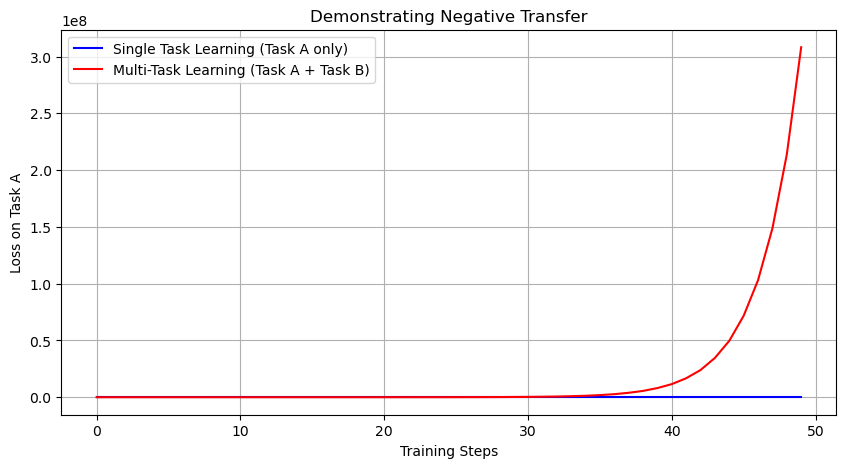

Final Task A Loss (STL): 2.5409292447875487e-09
Final Task A Loss (MTL): 308182784.0
------------------------------
Parameter Position STL: [1.9999715 1.9999715]
Parameter Position MTL: [14890.025 14890.025]


In [57]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(loss_STL, label='Single Task Learning (Task A only)', color='blue')
plt.plot(loss_MTL, label='Multi-Task Learning (Task A + Task B)', color='red')
plt.xlabel('Training Steps')
plt.ylabel('Loss on Task A')
plt.title('Demonstrating Negative Transfer')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Task A Loss (STL): {loss_STL[-1]}")
print(f"Final Task A Loss (MTL): {loss_MTL[-1]:}")
print("-" * 30)
print(f"Parameter Position STL: {theta_STL}")
print(f"Parameter Position MTL: {theta_MTL}")

In the Blue line (STL), we trained only on Task A, and the loss went to zero (perfect convergence).

In the Red line (MTL), we tried to learn both. Because of the Gradient Interference we visualized earlier, the model was pulled away from Task A's goal.

The final loss for Task A is significantly higher in the MTL setting. This gap between the Blue and Red lines is the definition of Negative Transfer. The presence of Task B actively hurt the learning of Task A.

---

## 2. Static Heuristics, Why they Work, and Why they Fail?

## (i) The "Success" Case
We'll implement a minimal PCGrad style rule that says:
```
If two gradients are conflicting (cosine_sim < 0), then remove the projection of the smaller gradient onto the larger one.
```

This will address:
- directional conflict
- magnitude dominance

In [84]:
def project(g_A, g_B):

    proj = (torch.dot(g_A, g_B)/ torch.dot(g_B, g_B)) * g_B

    return proj

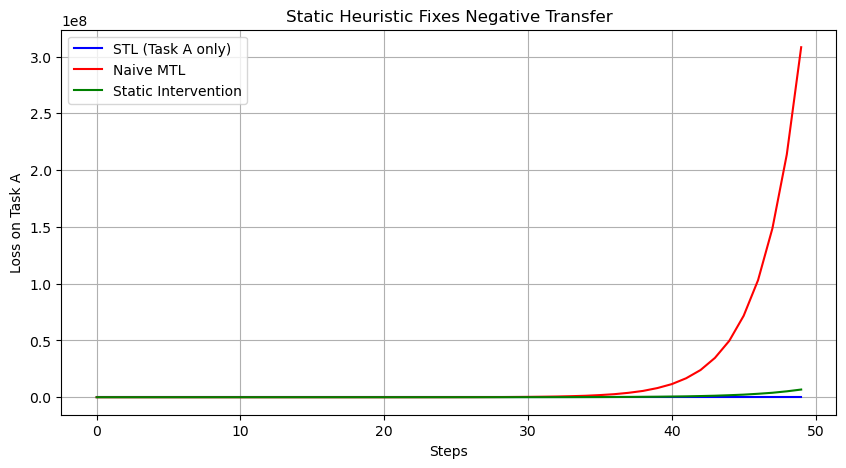

In [ ]:
def static_intervention(g_A, g_B):
    cos_sim = cosine_similarity(g_A, g_B, dim=0)

    if cos_sim < 0:
        # project smaller gradient only
        if torch.norm(g_A) < torch.norm(g_B):
            g_A = g_A - project(g_A, g_B)
        else:
            g_B = g_B - project(g_B, g_A)

    return g_A + g_B




def train_static_intervention(steps=50):
    theta = torch.tensor([0.0, 0.0], requires_grad=True)
    lr = 0.0975

    loss_history_A = []

    for _ in range(steps):
        g_A, g_B = get_task_gradients(theta)

        g_final = static_intervention(g_A, g_B)

        with torch.no_grad():
            theta -= lr * g_final

        target_A = torch.tensor([2.0, 2.0])
        loss_A = torch.sum((theta - target_A) ** 2)
        
        loss_history_A.append(loss_A.item())

    return theta.detach().numpy(), loss_history_A



theta_static, loss_static = train_static_intervention()

plt.figure(figsize=(10,5))
plt.plot(loss_STL, label="STL (Task A only)", color="blue")
plt.plot(loss_MTL, label="Naive MTL", color="red")
plt.plot(loss_static, label="Static Intervention", color="green")

plt.xlabel("Steps")
plt.ylabel("Loss on Task A")
plt.title("Static Heuristic Fixes Negative Transfer")
plt.legend()
plt.grid(True)
plt.show()


AHA!

Now we notice that static intervention/heuristic prevents divergence and its loss is much closer to STL and task A converges again, so we can say that negative transfer is somewhat fixed.

## (ii) The "Failure" Case
The problem with static rules are that:
```
They assume gradient conflict is always bad even when it becomes temporarily useful
```

- Early in the training the conflict between both tasks helps projection
- and Later, they naturally align
- Static rules keeps inferring away
- this results in slower convergence or worse final solution

In [111]:
# We modify task B to change over time!!
# oppose Task A early
# but gradually align with task A later on


def get_task_gradients_time(theta_input, step, switch_step=20):
    if theta_input.grad is not None:
        theta_input.grad.zero_()

    # Task A always wants (2,2)
    target_A = torch.tensor([2.0, 2.0])
    loss_A = torch.sum((theta_input - target_A) ** 2)
    loss_A.backward(retain_graph=True)
    grad_A = theta_input.grad.clone()

    theta_input.grad.zero_()

    # Task B switches behavior-------------------
    if step < switch_step:
        # conflicting early
        target_B = torch.tensor([-2.0, -2.0])
    
    
    else:
        # helpful later
        target_B = torch.tensor([2.0, 2.0])

    loss_B = torch.sum((theta_input - target_B) ** 2) * 5.0
    loss_B.backward(retain_graph=True)
    grad_B = theta_input.grad.clone()

    return grad_A, grad_B


In [ ]:
#def project(g1, g2):
#    return (torch.dot(g1, g2) / torch.dot(g2, g2)) * g2



def static_intervention_bad(g_A, g_B):
    #cos_sim = cosine_similarity(g_A, g_B, dim=0)

    #if cos_sim < 0:
    #    g_A = g_A - project(g_A, g_B)

    return g_A + 0.2 * g_B



This rule **never adapts**

To demonstrate this failure, the heuristic must be rigid even when the task relationships change, which is exactly what learned policies like AIM avoid.

In [ ]:
def train_with_static_failure(mode, steps=50, lr=0.05):
    theta = torch.tensor([0.0, 0.0], requires_grad=True)
    history_A = []

    for step in range(steps):
        gA, gB = get_task_gradients_time(theta, step)

        if mode == "naive":
            g = gA + gB
        
        elif mode == "static_bad":
            g = static_intervention_bad(gA, gB)

        with torch.no_grad():
            theta -= lr * g

        loss_A = torch.sum((theta - torch.tensor([2.0, 2.0])) ** 2)
        history_A.append(loss_A.item())

    return history_A


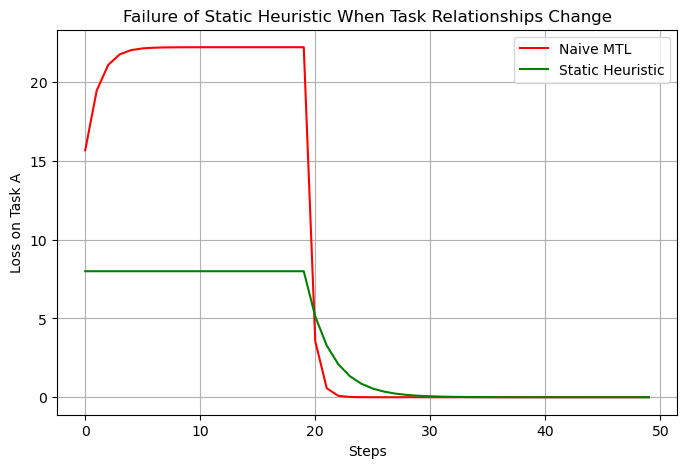

In [122]:
loss_naive = train_with_static_failure("naive")
loss_static = train_with_static_failure("static_bad")

plt.figure(figsize=(8,5))
plt.plot(loss_naive, label="Naive MTL", color="red")
plt.plot(loss_static, label="Static Heuristic", color="green")
plt.xlabel("Steps")
plt.ylabel("Loss on Task A")
plt.title("Failure of Static Heuristic When Task Relationships Change")
plt.legend()
plt.grid(True)
plt.show()


This shows us that in early stages, static heuristics help reduce conflict. After alignment, native MTL accelerates while static heuristics slightly lag and converge slower.


---

# 3. Adaptive Intervention Model (AIM)

This is the core of the paper. To implement Algorithm 1 from the Appendix, we need to treat the optimization process differently than standard PyTorch training.

Instead of ```loss.backward()``` $\rightarrow$ ```optimzer.step()```, AIM requires us to:
- Compute gradients for each task separately.
- Manipulate them using a second neural network (The **Policy**)
- Calculate a specific loss for that Policy using a **Guidance Set**
- Update both the Main model and the Policy

## (i) Simple MTL Model 
This is going to be our main neural network (Backbone + Heads)

## (ii) AIM Policy Model
This will contain the policy network ($\tau$, $\Phi$) and the intervention logic

## (iii) Training AIM 
And now finally, we will implement the algorithm found in Appendix A.1 (the pseudocode for how AIM trains).

Were going to create 100 samples in a simple dataset using ```sklearn.datasets.make_regression``` because itll allow us to create a perfect multi-task dataset with three tasks (target) from same input features. It requires no downloading, no processing, and we can contrrol the noise.

In [123]:
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from simple_mtl_model import SimpleMTLModel
from aim_policy import AIMPolicy

### Lets create the simplest possible MTL Datset

3 Regression Tasks from the same 20 input features

In [125]:
X, y = make_regression(n_samples=200, n_features=20, n_targets=3, noise=0.1, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [126]:
# 80-20 split where 80% is primary training, 10% is guidance, and other 10% is test

X_primary, X_guide, y_primary, y_guide = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Setup

In [128]:
input_dim = 20
hidden_dim = 64
num_tasks =3


main_model = SimpleMTLModel(input_dim, hidden_dim, num_tasks) # our main prediction model 

policy = AIMPolicy(num_tasks, policy_type='matrix') # aim policy model

In [129]:
# Optimizers

optimizer_model = optim.Adam(main_model.parameters(), lr=0.001)
optimizer_policy = optim.Adam(policy.parameters(), lr=0.01)

# Hyperparams from paper
lambda_guidance = 1.0
lambda_magnitude = 0.01
lambda_progress = 0.1

losses_log = []

### Training